# LSTM using PyTorch 
yo i got u this notebook uses pytorch for LSTM forecasting model 

thank me this is my email : AlhanoufAbdulraqib@gmail.com 


In [2]:
import math, time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd 
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the data

In [14]:
#load csv file into dataframe
df_main = pd.read_csv("/Users/hanouf/Desktop/SolarPowerProject/Data/cleaned_data.csv")

In [15]:
features_ig = [
    "Total Solar Irradiance on Horizontal Plane GHI(Wh/m2)",
    "Soiling Loss Index Isc(%)",
    "Soiling Loss Index Geff(%)",
    "Total Solar Irradiance on Horizontal Plane GHI(W/m2)",
    "Module Surface Temperature2(degree centigrade)",
    "Module Surface Temperature1(degree centigrade)",
    "Temperature Reference Cell(Deg C)",
    "Temperature Test(Deg C)",
    "Ambient Temp.(degree centigrade)",
    "Relative Humidity(%)"
]
TARGET = "active_power"

# configuration

In [16]:
FEATS  = features_ig         
WINDOW_SIZES = [30, 60, 120]
HORIZON = 1
VAL_FRAC = 0.10
TEST_FRAC = 0.20
BATCH_SIZE = 256
EPOCHS = 200
PATIENCE = 10
SEED = 42

#Reproducibility
import random, numpy as np, torch
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")


# Split & Scale Data

In [17]:
#Split chronologically
df = df_main.sort_index().copy()
n = len(df)
test_cut = int(n * (1 - TEST_FRAC))
trainval, test = df.iloc[:test_cut], df.iloc[test_cut:]
val_cut = int(len(trainval) * (1 - VAL_FRAC))
train, val = trainval.iloc[:val_cut], trainval.iloc[val_cut:]

X_train, X_val, X_test = train[FEATS].values, val[FEATS].values, test[FEATS].values
y_train, y_val, y_test = train[TARGET].values.reshape(-1,1), val[TARGET].values.reshape(-1,1), test[TARGET].values.reshape(-1,1)

In [18]:
#Scale features
x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
X_train, X_val, X_test = x_scaler.transform(X_train), x_scaler.transform(X_val), x_scaler.transform(X_test)
y_train, y_val, y_test = y_scaler.transform(y_train), y_scaler.transform(y_val), y_scaler.transform(y_test)

In [19]:
joblib.dump(x_scaler, "x_scaler.pkl")
joblib.dump(y_scaler, "y_scaler.pkl")

['y_scaler.pkl']

# Data loader 

In [20]:
class SeqDataset(Dataset):
    def __init__(self, X, y):
        # X: (N, W, F) float32, y: (N,) float32
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

# LSTM models

### *Vanilla LSTM*

In [21]:
# Vanilla LSTM
class VanillaLSTMReg(nn.Module):
    def __init__(self, n_features, hidden=64, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden,
            num_layers=1,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):               # x: (B, W, F)
        out, _ = self.lstm(x)           # (B, W, H)
        last = out[:, -1, :]            # (B, H)
        last = self.dropout(last)
        return self.fc(last).squeeze(-1)

### *Stacked LSTM*

In [22]:
# Stacked LSTM (128 -> 64)
# Mirrors: LSTM(128, return_sequences=True, ...), then LSTM(64, ...)
class StackedLSTMReg(nn.Module):
    def __init__(self, n_features,
                 hidden1=128, hidden2=64,
                 dropout1=0.01, dropout2=0.2):
        super().__init__()
        self.lstm1 = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden1,
            num_layers=1,
            batch_first=True
        )
        self.do1 = nn.Dropout(dropout1)

        self.lstm2 = nn.LSTM(
            input_size=hidden1,
            hidden_size=hidden2,
            num_layers=1,
            batch_first=True
        )
        self.do2 = nn.Dropout(dropout2)

        self.fc = nn.Linear(hidden2, 1)

    def forward(self, x):               # (B, W, F)
        out1, _ = self.lstm1(x)         # (B, W, H1)  (return_sequences=True)
        out1 = self.do1(out1)
        out2, _ = self.lstm2(out1)      # (B, W, H2)
        last = out2[:, -1, :]           # (B, H2)
        last = self.do2(last)
        return self.fc(last).squeeze(-1)

### *Bidirectional LSTM*

In [23]:
# Bidirectional LSTM
# Mirrors: Bi(LSTM(128, return_sequences=True)), then Bi(LSTM(64))
class BiLSTMReg(nn.Module):
    def __init__(self, n_features,
                 hidden1=128, hidden2=64,
                 dropout=0.2):
        super().__init__()
        self.bi1 = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden1,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.do1 = nn.Dropout(dropout)

        self.bi2 = nn.LSTM(
            input_size=hidden1*2,   # because bidirectional doubles features
            hidden_size=hidden2,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.do2 = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden2*2, 1)  # *2 for bidirectional

    def forward(self, x):                  # (B, W, F)
        out1, _ = self.bi1(x)              # (B, W, 2*H1)
        out1 = self.do1(out1)
        out2, _ = self.bi2(out1)           # (B, W, 2*H2)
        last = out2[:, -1, :]              # (B, 2*H2)
        last = self.do2(last)
        return self.fc(last).squeeze(-1)

### *CNN + LSTM*

In [24]:
# CNN + LSTM 
# Mirrors: Conv1D(64,3,causal)->MaxPool1d(2)->Conv1D(64,3,causal)->LSTM(64)
# Note: true "causal" padding in PyTorch Conv1d needs manual left-padding; here I use 'same-ish' padding=1.
class CNNLSTMReg(nn.Module):
    def __init__(self, n_features, conv_channels=64, kernel_size=3,
                 pool=2, lstm_hidden=64, dropout=0.2):
        super().__init__()
        # Conv1d expects (B, C, L) so we treat features as channels and time as length
        pad = kernel_size // 2  # approx "same"
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=conv_channels,
                               kernel_size=kernel_size, padding=pad)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=pool)

        self.conv2 = nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels,
                               kernel_size=kernel_size, padding=pad)
        self.relu2 = nn.ReLU()

        self.lstm = nn.LSTM(
            input_size=conv_channels,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True
        )
        self.do = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):                 # x: (B, W, F)
        # -> (B, F, W) for Conv1d
        z = x.transpose(1, 2)             # (B, F, W)
        z = self.relu1(self.conv1(z))     # (B, C, W)
        z = self.pool1(z)                 # (B, C, W//2)
        z = self.relu2(self.conv2(z))     # (B, C, W//2)

        # back to (B, W', C) for LSTM
        z = z.transpose(1, 2)             # (B, W', C)
        out, _ = self.lstm(z)             # (B, W', H)
        last = out[:, -1, :]              # (B, H)
        last = self.do(last)
        return self.fc(last).squeeze(-1)
  # (B,)

In [25]:
def make_sequences(X, y, window, horizon=1):
    xs, ys = [], []
    for i in range(len(X) - window - horizon + 1):
        xs.append(X[i:i+window])
        ys.append(y[i+window+horizon-1, 0])
    return np.asarray(xs, np.float32), np.asarray(ys, np.float32)

In [26]:
def inverse_metrics(y_true_sc, y_pred_sc):
    yt = y_scaler.inverse_transform(y_true_sc.reshape(-1,1)).ravel()
    yp = y_scaler.inverse_transform(y_pred_sc.reshape(-1,1)).ravel()
    mae  = mean_absolute_error(yt, yp)
    rmse = mean_squared_error(yt, yp, squared=False)
    r2   = r2_score(yt, yp)
    return mae, rmse, r2, yt, yp


# Training & Evaluation

In [27]:
# Train / Eval 
def run_epoch(model, loader, criterion, optimizer=None):
    train = optimizer is not None
    model.train() if train else model.eval()
    losses, preds, trues = [], [], []
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            yhat = model(xb)
            loss = criterion(yhat, yb)
            if train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            losses.append(loss.item())
            preds.append(yhat.detach().cpu())
            trues.append(yb.detach().cpu())
    if not preds:
        return float("nan"), None, None
    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()
    return float(sum(losses) / len(losses)), trues, preds


def train_one_window(kind, Xtr, ytr, Xva, yva, W,
                     batch=BATCH_SIZE, epochs=EPOCHS, patience=PATIENCE):
    n_features = Xtr.shape[-1]

    # pick model
    kind = kind.lower()
    if kind == "vanilla":
        model = VanillaLSTMReg(n_features)
    elif kind == "stacked":
        model = StackedLSTMReg(n_features)
    elif kind in ("bi", "bidirectional"):
        model = BiLSTMReg(n_features)
    elif kind in ("cnn_lstm", "cnn-lstm"):
        model = CNNLSTMReg(n_features)
    else:
        raise ValueError(f"unknown model kind: {kind}")
    model = model.to(DEVICE)

    crit = nn.MSELoss()
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="min", factor=0.5, patience=4, min_lr=1e-5, verbose=True
    )

    # ensure dtypes/shapes are good: X: (N,W,F) float32, y: (N,) float32
    dtr = DataLoader(SeqDataset(Xtr, ytr), batch_size=batch, shuffle=False)
    dva = DataLoader(SeqDataset(Xva, yva), batch_size=batch, shuffle=False)

    history = {"loss": [], "val_loss": [], "mae": [], "val_mae": [], "mape": [], "val_mape": []}
    best_val = float("inf"); best_state = None; wait = 0

    for ep in range(1, epochs + 1):
        tr_loss, yt_tr, yp_tr = run_epoch(model, dtr, crit, optimizer=opt)
        va_loss, yt_va, yp_va = run_epoch(model, dva, crit, optimizer=None)

        # scaled-domain metrics (to mirror TF logs)
        tr_mae = float(np.mean(np.abs(yt_tr - yp_tr))) if yt_tr is not None else float("nan")
        tr_mape = float(np.mean(np.abs((yt_tr - yp_tr) / np.maximum(np.abs(yt_tr), 1e-8)))) * 100 if yt_tr is not None else float("nan")
        va_mae_sc = float(np.mean(np.abs(yt_va - yp_va)))
        va_mape_sc = float(np.mean(np.abs((yt_va - yp_va) / np.maximum(np.abs(yt_va), 1e-8)))) * 100

        history["loss"].append(tr_loss);      history["val_loss"].append(va_loss)
        history["mae"].append(tr_mae);        history["val_mae"].append(va_mae_sc)
        history["mape"].append(tr_mape);      history["val_mape"].append(va_mape_sc)

        sched.step(va_loss)
        print(f"Epoch {ep:03d} | loss {tr_loss:.4f} val_loss {va_loss:.4f} | mae(sc) {tr_mae:.4f} val_mae(sc) {va_mae_sc:.4f} | mape% {tr_mape:.2f} val_mape% {va_mape_sc:.2f}")

        if va_loss < best_val - 1e-6:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history


## Training loop 

### VanillaLSTM

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | loss 0.0498 val_loss 0.0093 | mae(sc) 0.1278 val_mae(sc) 0.0618 | mape% 63.91 val_mape% 17.49
Epoch 002 | loss 0.0301 val_loss 0.0063 | mae(sc) 0.0944 val_mae(sc) 0.0526 | mape% 58.01 val_mape% 12.44
Epoch 003 | loss 0.0291 val_loss 0.0051 | mae(sc) 0.0913 val_mae(sc) 0.0469 | mape% 54.43 val_mape% 10.18
Epoch 004 | loss 0.0283 val_loss 0.0048 | mae(sc) 0.0889 val_mae(sc) 0.0459 | mape% 52.20 val_mape% 10.66
Epoch 005 | loss 0.0276 val_loss 0.0047 | mae(sc) 0.0871 val_mae(sc) 0.0464 | mape% 51.79 val_mape% 11.16
Epoch 006 | loss 0.0270 val_loss 0.0047 | mae(sc) 0.0858 val_mae(sc) 0.0474 | mape% 49.51 val_mape% 11.51
Epoch 007 | loss 0.0265 val_loss 0.0046 | mae(sc) 0.0846 val_mae(sc) 0.0458 | mape% 48.61 val_mape% 11.59
Epoch 008 | loss 0.0260 val_loss 0.0045 | mae(sc) 0.0834 val_mae(sc) 0.0455 | mape% 47.09 val_mape% 11.41
Epoch 009 | loss 0.0256 val_loss 0.0043 | mae(sc) 0.0826 val_mae(sc) 0.0439 | mape% 43.75 val_mape% 11.28
Epoch 010 | loss 0.0252 val_loss 0.0042 | mae(

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[W=30] TEST: MAE=16886.822 RMSE=28894.121 R2=0.924


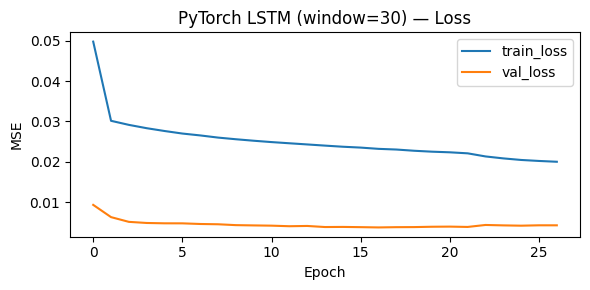

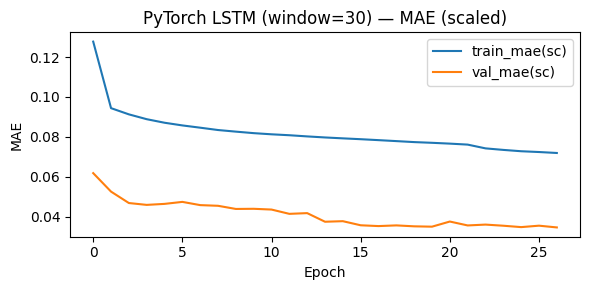

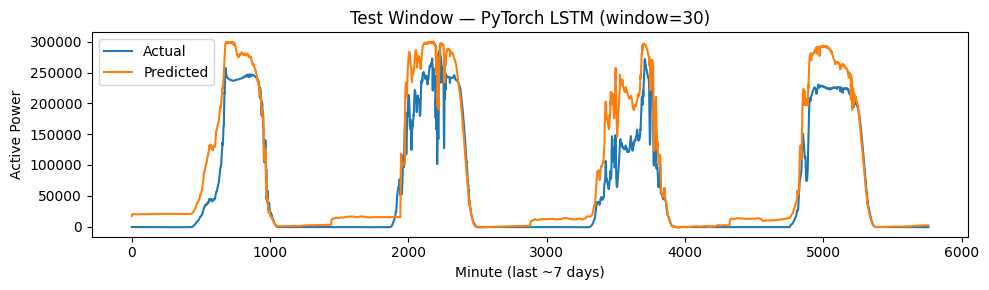

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | loss 0.0452 val_loss 0.0084 | mae(sc) 0.1237 val_mae(sc) 0.0584 | mape% 64.36 val_mape% 18.37
Epoch 002 | loss 0.0299 val_loss 0.0066 | mae(sc) 0.0939 val_mae(sc) 0.0547 | mape% 56.71 val_mape% 14.02
Epoch 003 | loss 0.0289 val_loss 0.0054 | mae(sc) 0.0905 val_mae(sc) 0.0490 | mape% 53.82 val_mape% 11.31
Epoch 004 | loss 0.0281 val_loss 0.0047 | mae(sc) 0.0879 val_mae(sc) 0.0448 | mape% 52.55 val_mape% 10.86
Epoch 005 | loss 0.0275 val_loss 0.0045 | mae(sc) 0.0865 val_mae(sc) 0.0445 | mape% 51.69 val_mape% 10.76
Epoch 006 | loss 0.0269 val_loss 0.0044 | mae(sc) 0.0852 val_mae(sc) 0.0428 | mape% 51.84 val_mape% 10.63
Epoch 007 | loss 0.0265 val_loss 0.0044 | mae(sc) 0.0841 val_mae(sc) 0.0436 | mape% 49.57 val_mape% 10.99
Epoch 008 | loss 0.0260 val_loss 0.0043 | mae(sc) 0.0831 val_mae(sc) 0.0432 | mape% 49.13 val_mape% 11.16
Epoch 009 | loss 0.0257 val_loss 0.0042 | mae(sc) 0.0825 val_mae(sc) 0.0435 | mape% 47.49 val_mape% 11.33
Epoch 010 | loss 0.0254 val_loss 0.0040 | mae(

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


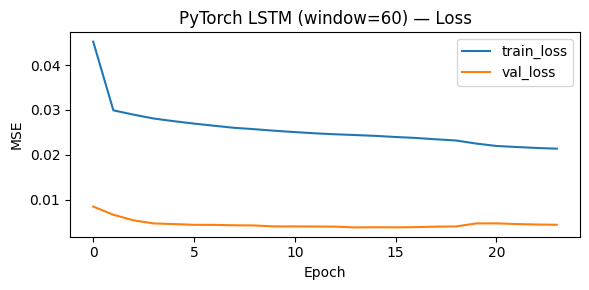

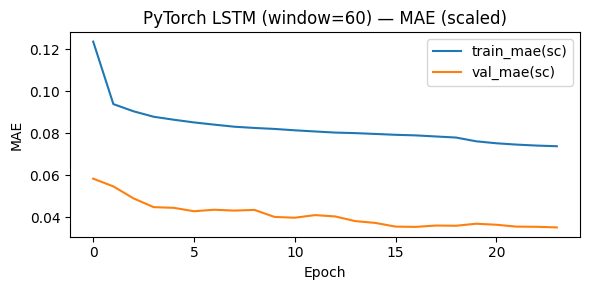

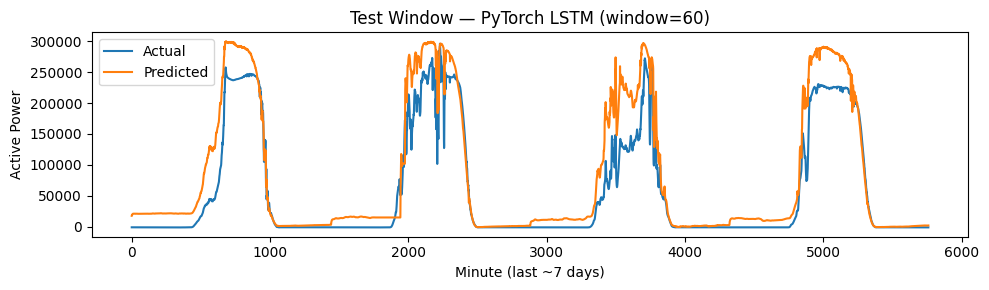

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | loss 0.0458 val_loss 0.0078 | mae(sc) 0.1241 val_mae(sc) 0.0582 | mape% 67.47 val_mape% 17.36
Epoch 002 | loss 0.0300 val_loss 0.0060 | mae(sc) 0.0933 val_mae(sc) 0.0518 | mape% 57.46 val_mape% 13.30
Epoch 003 | loss 0.0293 val_loss 0.0051 | mae(sc) 0.0903 val_mae(sc) 0.0475 | mape% 55.62 val_mape% 10.98
Epoch 004 | loss 0.0285 val_loss 0.0048 | mae(sc) 0.0880 val_mae(sc) 0.0453 | mape% 52.58 val_mape% 10.86
Epoch 005 | loss 0.0279 val_loss 0.0046 | mae(sc) 0.0865 val_mae(sc) 0.0442 | mape% 52.90 val_mape% 10.62
Epoch 006 | loss 0.0273 val_loss 0.0044 | mae(sc) 0.0851 val_mae(sc) 0.0425 | mape% 52.12 val_mape% 10.44
Epoch 007 | loss 0.0268 val_loss 0.0042 | mae(sc) 0.0842 val_mae(sc) 0.0408 | mape% 50.92 val_mape% 10.27
Epoch 008 | loss 0.0263 val_loss 0.0041 | mae(sc) 0.0833 val_mae(sc) 0.0409 | mape% 50.42 val_mape% 10.12
Epoch 009 | loss 0.0260 val_loss 0.0040 | mae(sc) 0.0827 val_mae(sc) 0.0387 | mape% 50.57 val_mape% 10.09
Epoch 010 | loss 0.0256 val_loss 0.0041 | mae(

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[W=120] TEST: MAE=17448.236 RMSE=29247.910 R2=0.922


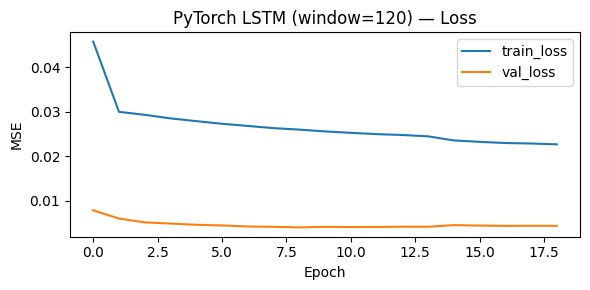

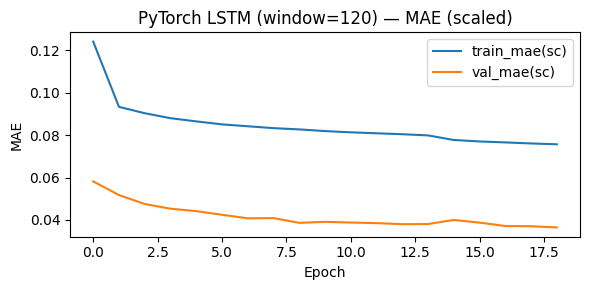

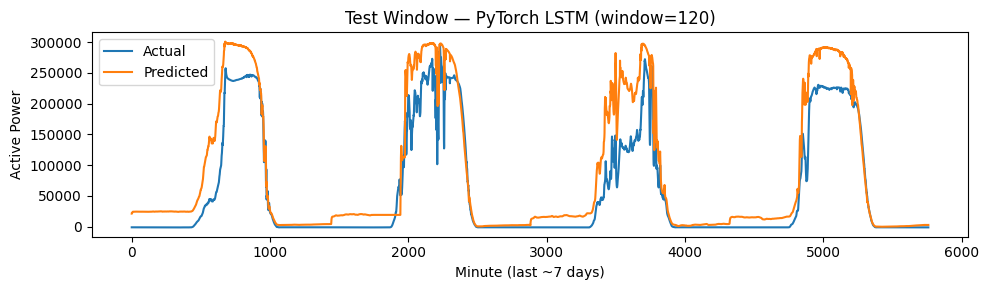

In [28]:
results_pt = {}

for W in WINDOW_SIZES:
    # build windowed tensors exactly like your TF code
    Xtr, ytr = make_sequences(X_train, y_train, window=W, horizon=HORIZON)
    Xva, yva = make_sequences(X_val,   y_val,   window=W, horizon=HORIZON)
    Xte, yte = make_sequences(X_test,  y_test,  window=W, horizon=HORIZON)

    model, hist = train_one_window("vanilla",Xtr, ytr.ravel(), Xva, yva.ravel(), W)

    # test inference
    dte = DataLoader(SeqDataset(Xte, yte.ravel()), batch_size=BATCH_SIZE, shuffle=False)
    te_loss, y_true_sc, y_pred_sc = run_epoch(model, dte, nn.MSELoss(), optimizer=None)

    # inverse to original scale + metrics in your style
    mae, rmse, r2, y_true_inv, y_pred_inv = inverse_metrics(y_true_sc, y_pred_sc)
    results_pt[W] = {"history": hist, "metrics": (mae, rmse, r2), "y_true": y_true_inv, "y_pred": y_pred_inv}

    print(f"[W={W}] TEST: MAE={mae:.3f} RMSE={rmse:.3f} R2={r2:.3f}")

    # plots like your TF version
    plt.figure(figsize=(6,3))
    plt.plot(hist["loss"], label="train_loss"); plt.plot(hist["val_loss"], label="val_loss")
    plt.title(f"PyTorch LSTM (window={W}) — Loss"); plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(hist["mae"], label="train_mae(sc)"); plt.plot(hist["val_mae"], label="val_mae(sc)")
    plt.title(f"PyTorch LSTM (window={W}) — MAE (scaled)"); plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend(); plt.tight_layout(); plt.show()

    steps = min(len(y_true_inv), 4*24*60)
    plt.figure(figsize=(10,3))
    plt.plot(y_true_inv[-steps:], label="Actual")
    plt.plot(y_pred_inv[-steps:], label="Predicted")
    plt.title(f"Test Window — PyTorch LSTM (window={W})")
    plt.xlabel("Minute (last ~7 days)"); plt.ylabel("Active Power")
    plt.legend(); plt.tight_layout(); plt.show()

    # save best checkpoint (state_dict) per window, match your naming
    torch.save(
        {
            "state_dict": model.state_dict(),
            "n_features": Xtr.shape[-1],
            "window": W,
            "target": TARGET,
            "features": FEATS,
            "scalers": {
                "x_scaler_path": "x_scaler.pkl",
                "y_scaler_path": "y_scaler.pkl",
            },
        },
        f"VanillaLSTM_IG{W}.pt"
    )


### StackedLSTM

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | loss 0.0455 val_loss 0.0093 | mae(sc) 0.1266 val_mae(sc) 0.0602 | mape% 71.75 val_mape% 18.43
Epoch 002 | loss 0.0322 val_loss 0.0081 | mae(sc) 0.1022 val_mae(sc) 0.0560 | mape% 56.34 val_mape% 16.18
Epoch 003 | loss 0.0310 val_loss 0.0066 | mae(sc) 0.0989 val_mae(sc) 0.0502 | mape% 56.51 val_mape% 13.55
Epoch 004 | loss 0.0303 val_loss 0.0055 | mae(sc) 0.0973 val_mae(sc) 0.0452 | mape% 55.39 val_mape% 11.66
Epoch 005 | loss 0.0297 val_loss 0.0048 | mae(sc) 0.0960 val_mae(sc) 0.0425 | mape% 54.71 val_mape% 10.63
Epoch 006 | loss 0.0290 val_loss 0.0048 | mae(sc) 0.0950 val_mae(sc) 0.0418 | mape% 52.33 val_mape% 10.04
Epoch 007 | loss 0.0283 val_loss 0.0044 | mae(sc) 0.0936 val_mae(sc) 0.0394 | mape% 48.42 val_mape% 9.84
Epoch 008 | loss 0.0278 val_loss 0.0043 | mae(sc) 0.0926 val_mae(sc) 0.0391 | mape% 46.77 val_mape% 10.08
Epoch 009 | loss 0.0272 val_loss 0.0044 | mae(sc) 0.0917 val_mae(sc) 0.0411 | mape% 44.31 val_mape% 10.98
Epoch 010 | loss 0.0267 val_loss 0.0044 | mae(s

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[W=30] TEST: MAE=14589.364 RMSE=25590.875 R2=0.940


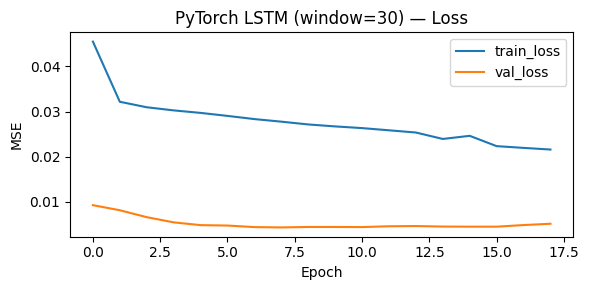

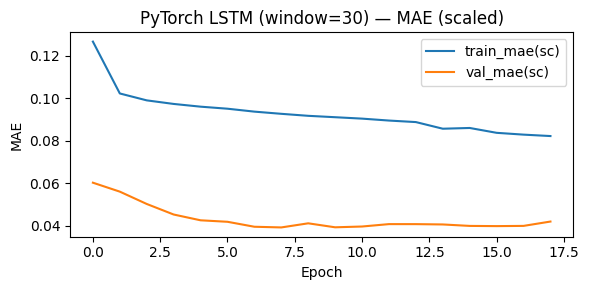

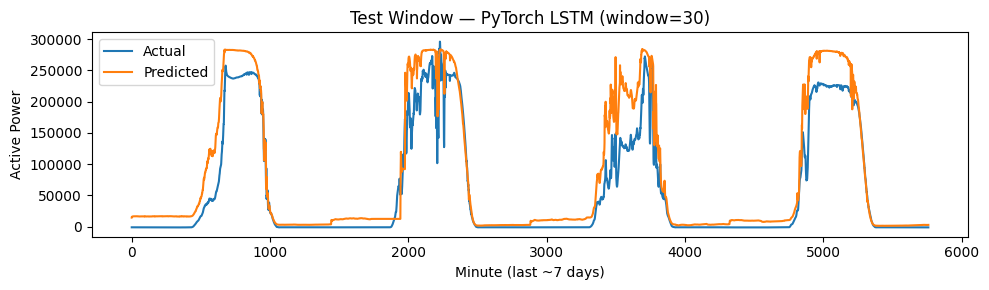

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | loss 0.0448 val_loss 0.0087 | mae(sc) 0.1245 val_mae(sc) 0.0562 | mape% 67.21 val_mape% 17.26
Epoch 002 | loss 0.0319 val_loss 0.0078 | mae(sc) 0.1010 val_mae(sc) 0.0530 | mape% 56.07 val_mape% 15.89
Epoch 003 | loss 0.0308 val_loss 0.0061 | mae(sc) 0.0981 val_mae(sc) 0.0472 | mape% 54.55 val_mape% 13.26
Epoch 004 | loss 0.0303 val_loss 0.0054 | mae(sc) 0.0968 val_mae(sc) 0.0438 | mape% 56.85 val_mape% 12.50
Epoch 005 | loss 0.0296 val_loss 0.0049 | mae(sc) 0.0956 val_mae(sc) 0.0432 | mape% 53.68 val_mape% 11.00
Epoch 006 | loss 0.0292 val_loss 0.0045 | mae(sc) 0.0948 val_mae(sc) 0.0405 | mape% 54.27 val_mape% 10.69
Epoch 007 | loss 0.0285 val_loss 0.0044 | mae(sc) 0.0937 val_mae(sc) 0.0425 | mape% 51.51 val_mape% 11.01
Epoch 008 | loss 0.0280 val_loss 0.0042 | mae(sc) 0.0928 val_mae(sc) 0.0412 | mape% 50.37 val_mape% 11.08
Epoch 009 | loss 0.0273 val_loss 0.0043 | mae(sc) 0.0920 val_mae(sc) 0.0415 | mape% 47.88 val_mape% 10.96
Epoch 010 | loss 0.0268 val_loss 0.0039 | mae(

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


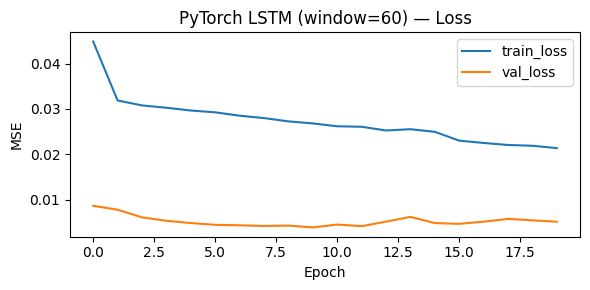

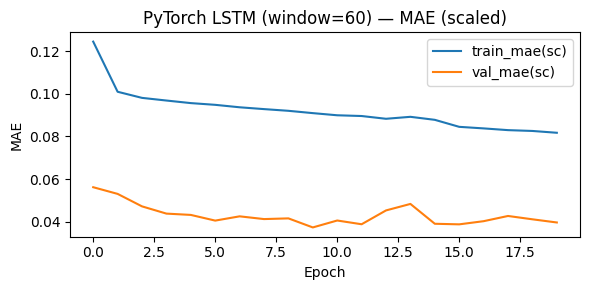

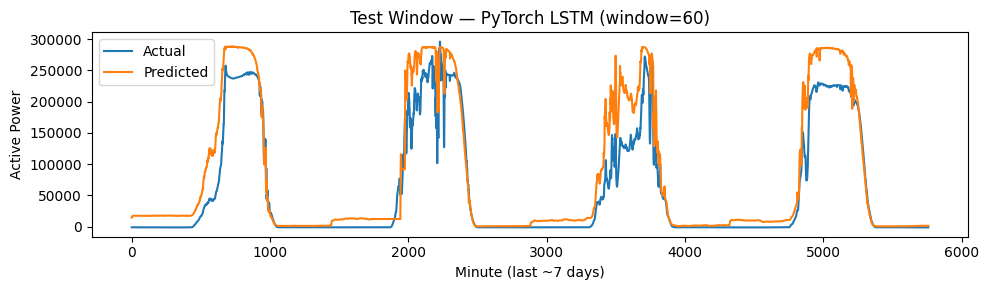

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | loss 0.0446 val_loss 0.0084 | mae(sc) 0.1262 val_mae(sc) 0.0560 | mape% 70.22 val_mape% 16.11
Epoch 002 | loss 0.0317 val_loss 0.0072 | mae(sc) 0.1023 val_mae(sc) 0.0508 | mape% 58.07 val_mape% 14.47
Epoch 003 | loss 0.0307 val_loss 0.0061 | mae(sc) 0.0997 val_mae(sc) 0.0468 | mape% 56.47 val_mape% 12.74
Epoch 004 | loss 0.0300 val_loss 0.0051 | mae(sc) 0.0977 val_mae(sc) 0.0433 | mape% 54.19 val_mape% 11.55
Epoch 005 | loss 0.0296 val_loss 0.0048 | mae(sc) 0.0968 val_mae(sc) 0.0421 | mape% 56.18 val_mape% 10.16
Epoch 006 | loss 0.0291 val_loss 0.0044 | mae(sc) 0.0955 val_mae(sc) 0.0403 | mape% 54.03 val_mape% 9.76
Epoch 007 | loss 0.0286 val_loss 0.0042 | mae(sc) 0.0946 val_mae(sc) 0.0389 | mape% 52.09 val_mape% 9.61
Epoch 008 | loss 0.0281 val_loss 0.0040 | mae(sc) 0.0936 val_mae(sc) 0.0377 | mape% 49.64 val_mape% 9.36
Epoch 009 | loss 0.0277 val_loss 0.0039 | mae(sc) 0.0928 val_mae(sc) 0.0359 | mape% 48.34 val_mape% 9.99
Epoch 010 | loss 0.0273 val_loss 0.0038 | mae(sc) 

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


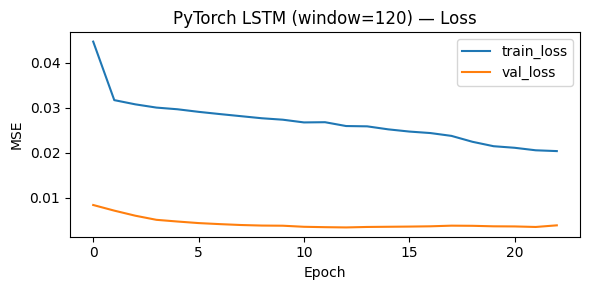

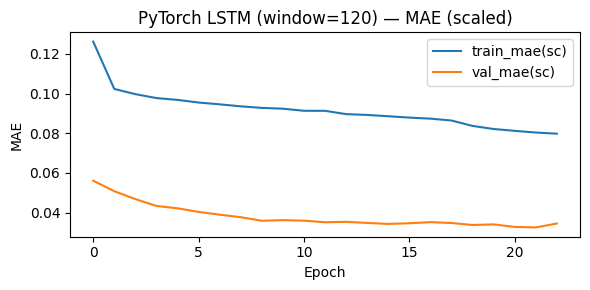

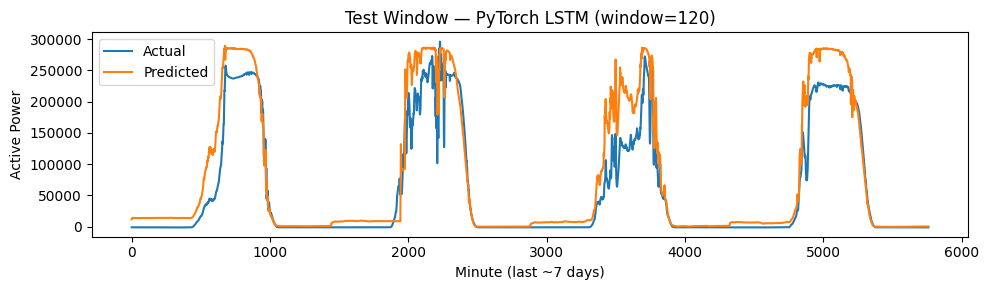

In [29]:
results_pt = {}

for W in WINDOW_SIZES:
    # build windowed tensors exactly like your TF code
    Xtr, ytr = make_sequences(X_train, y_train, window=W, horizon=HORIZON)
    Xva, yva = make_sequences(X_val,   y_val,   window=W, horizon=HORIZON)
    Xte, yte = make_sequences(X_test,  y_test,  window=W, horizon=HORIZON)

    model, hist = train_one_window("stacked",Xtr, ytr.ravel(), Xva, yva.ravel(), W)

    # test inference
    dte = DataLoader(SeqDataset(Xte, yte.ravel()), batch_size=BATCH_SIZE, shuffle=False)
    te_loss, y_true_sc, y_pred_sc = run_epoch(model, dte, nn.MSELoss(), optimizer=None)

    # inverse to original scale + metrics in your style
    mae, rmse, r2, y_true_inv, y_pred_inv = inverse_metrics(y_true_sc, y_pred_sc)
    results_pt[W] = {"history": hist, "metrics": (mae, rmse, r2), "y_true": y_true_inv, "y_pred": y_pred_inv}

    print(f"[W={W}] TEST: MAE={mae:.3f} RMSE={rmse:.3f} R2={r2:.3f}")

    # plots like your TF version
    plt.figure(figsize=(6,3))
    plt.plot(hist["loss"], label="train_loss"); plt.plot(hist["val_loss"], label="val_loss")
    plt.title(f"PyTorch LSTM (window={W}) — Loss"); plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(hist["mae"], label="train_mae(sc)"); plt.plot(hist["val_mae"], label="val_mae(sc)")
    plt.title(f"PyTorch LSTM (window={W}) — MAE (scaled)"); plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend(); plt.tight_layout(); plt.show()

    steps = min(len(y_true_inv), 4*24*60)
    plt.figure(figsize=(10,3))
    plt.plot(y_true_inv[-steps:], label="Actual")
    plt.plot(y_pred_inv[-steps:], label="Predicted")
    plt.title(f"Test Window — PyTorch LSTM (window={W})")
    plt.xlabel("Minute (last ~7 days)"); plt.ylabel("Active Power")
    plt.legend(); plt.tight_layout(); plt.show()

    # save best checkpoint (state_dict) per window, match your naming
    torch.save(
        {
            "state_dict": model.state_dict(),
            "n_features": Xtr.shape[-1],
            "window": W,
            "target": TARGET,
            "features": FEATS,
            "scalers": {
                "x_scaler_path": "x_scaler.pkl",
                "y_scaler_path": "y_scaler.pkl",
            },
        },
        f"StackedLSTM_IG{W}.pt"
    )


### BI LSTM

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | loss 0.0416 val_loss 0.0101 | mae(sc) 0.1177 val_mae(sc) 0.0603 | mape% 64.72 val_mape% 20.59
Epoch 002 | loss 0.0298 val_loss 0.0073 | mae(sc) 0.0940 val_mae(sc) 0.0512 | mape% 54.69 val_mape% 17.72
Epoch 003 | loss 0.0288 val_loss 0.0059 | mae(sc) 0.0901 val_mae(sc) 0.0451 | mape% 54.71 val_mape% 15.49
Epoch 004 | loss 0.0283 val_loss 0.0049 | mae(sc) 0.0887 val_mae(sc) 0.0409 | mape% 53.54 val_mape% 13.36
Epoch 005 | loss 0.0276 val_loss 0.0044 | mae(sc) 0.0873 val_mae(sc) 0.0386 | mape% 52.16 val_mape% 11.84
Epoch 006 | loss 0.0272 val_loss 0.0038 | mae(sc) 0.0864 val_mae(sc) 0.0353 | mape% 53.05 val_mape% 9.94
Epoch 007 | loss 0.0267 val_loss 0.0037 | mae(sc) 0.0854 val_mae(sc) 0.0379 | mape% 50.41 val_mape% 9.60
Epoch 008 | loss 0.0262 val_loss 0.0034 | mae(sc) 0.0846 val_mae(sc) 0.0359 | mape% 49.85 val_mape% 9.55
Epoch 009 | loss 0.0260 val_loss 0.0035 | mae(sc) 0.0845 val_mae(sc) 0.0365 | mape% 49.53 val_mape% 9.91
Epoch 010 | loss 0.0256 val_loss 0.0033 | mae(sc) 

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


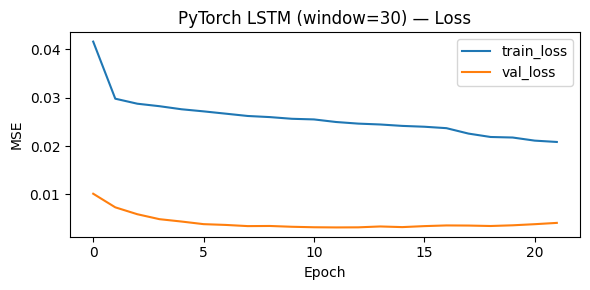

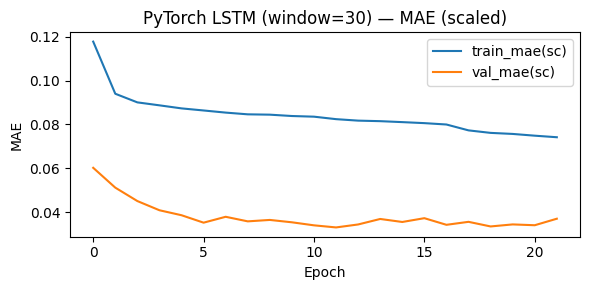

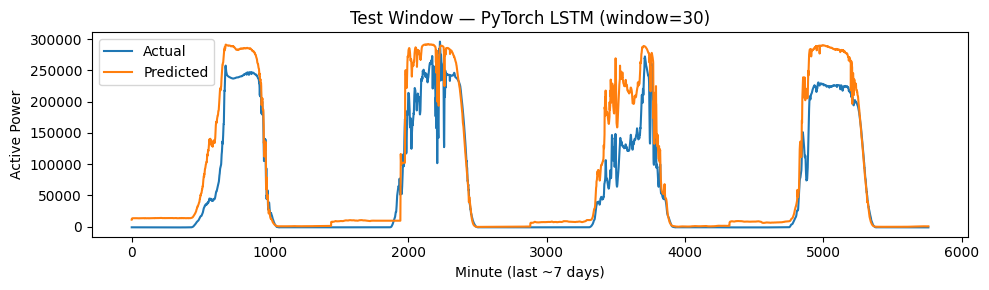

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | loss 0.0411 val_loss 0.0087 | mae(sc) 0.1145 val_mae(sc) 0.0545 | mape% 65.10 val_mape% 18.65
Epoch 002 | loss 0.0297 val_loss 0.0071 | mae(sc) 0.0934 val_mae(sc) 0.0506 | mape% 55.94 val_mape% 17.22
Epoch 003 | loss 0.0291 val_loss 0.0060 | mae(sc) 0.0903 val_mae(sc) 0.0459 | mape% 55.39 val_mape% 15.30
Epoch 004 | loss 0.0284 val_loss 0.0051 | mae(sc) 0.0884 val_mae(sc) 0.0421 | mape% 55.12 val_mape% 13.65
Epoch 005 | loss 0.0278 val_loss 0.0043 | mae(sc) 0.0870 val_mae(sc) 0.0378 | mape% 51.93 val_mape% 11.82
Epoch 006 | loss 0.0274 val_loss 0.0040 | mae(sc) 0.0862 val_mae(sc) 0.0373 | mape% 51.96 val_mape% 10.34
Epoch 007 | loss 0.0267 val_loss 0.0037 | mae(sc) 0.0851 val_mae(sc) 0.0343 | mape% 49.26 val_mape% 9.84
Epoch 008 | loss 0.0263 val_loss 0.0036 | mae(sc) 0.0843 val_mae(sc) 0.0354 | mape% 48.47 val_mape% 9.99
Epoch 009 | loss 0.0258 val_loss 0.0034 | mae(sc) 0.0837 val_mae(sc) 0.0339 | mape% 46.35 val_mape% 9.79
Epoch 010 | loss 0.0255 val_loss 0.0034 | mae(sc)

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


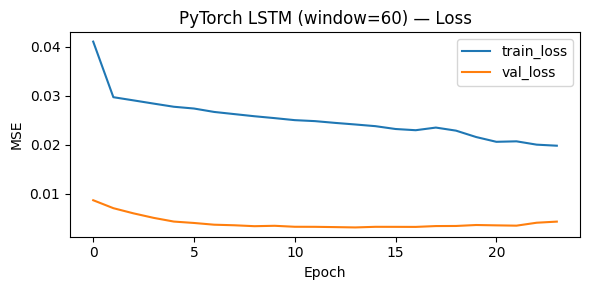

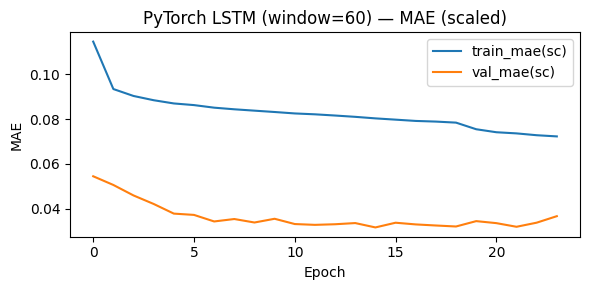

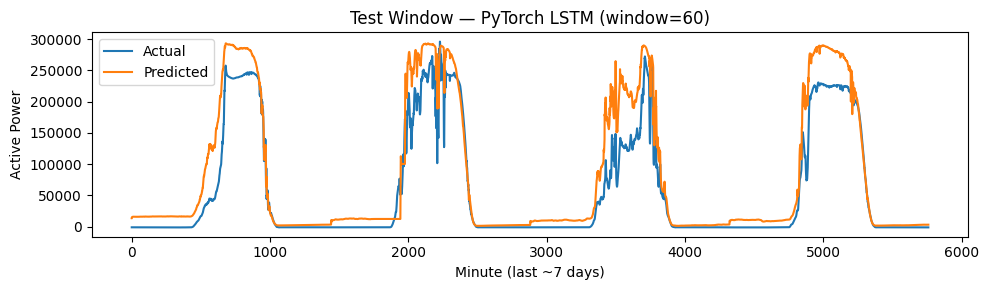

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | loss 0.0412 val_loss 0.0094 | mae(sc) 0.1167 val_mae(sc) 0.0574 | mape% 65.49 val_mape% 19.01
Epoch 002 | loss 0.0296 val_loss 0.0074 | mae(sc) 0.0929 val_mae(sc) 0.0531 | mape% 54.25 val_mape% 17.03
Epoch 003 | loss 0.0289 val_loss 0.0059 | mae(sc) 0.0901 val_mae(sc) 0.0460 | mape% 55.21 val_mape% 15.10
Epoch 004 | loss 0.0284 val_loss 0.0050 | mae(sc) 0.0884 val_mae(sc) 0.0412 | mape% 54.77 val_mape% 13.31
Epoch 005 | loss 0.0278 val_loss 0.0044 | mae(sc) 0.0870 val_mae(sc) 0.0382 | mape% 54.94 val_mape% 11.58
Epoch 006 | loss 0.0273 val_loss 0.0040 | mae(sc) 0.0860 val_mae(sc) 0.0365 | mape% 51.84 val_mape% 10.53
Epoch 007 | loss 0.0269 val_loss 0.0038 | mae(sc) 0.0850 val_mae(sc) 0.0356 | mape% 51.27 val_mape% 9.79
Epoch 008 | loss 0.0264 val_loss 0.0037 | mae(sc) 0.0842 val_mae(sc) 0.0354 | mape% 51.36 val_mape% 9.51
Epoch 009 | loss 0.0261 val_loss 0.0037 | mae(sc) 0.0837 val_mae(sc) 0.0363 | mape% 47.39 val_mape% 10.15
Epoch 010 | loss 0.0258 val_loss 0.0036 | mae(sc

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


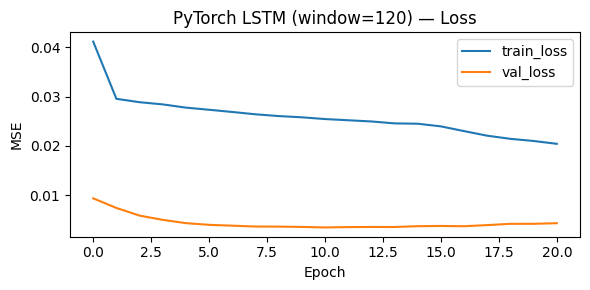

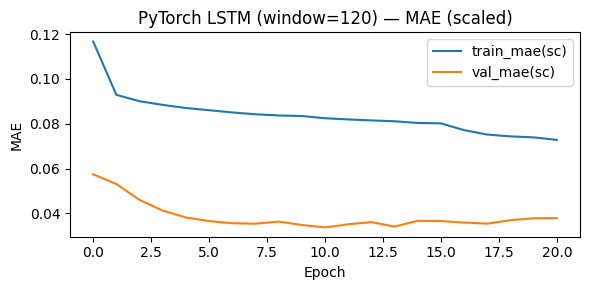

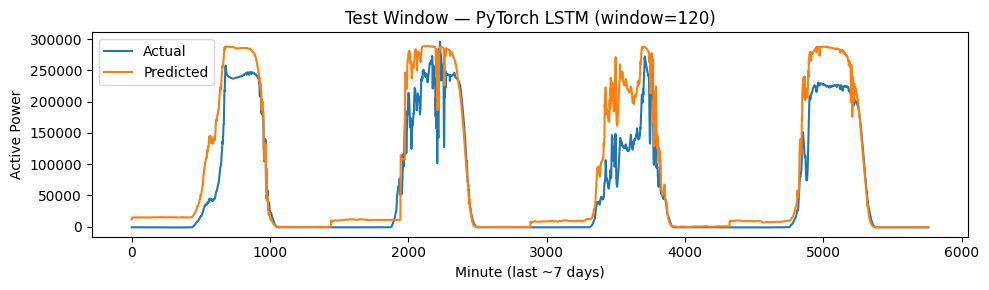

In [30]:
results_pt = {}

for W in WINDOW_SIZES:
    # build windowed tensors exactly like your TF code
    Xtr, ytr = make_sequences(X_train, y_train, window=W, horizon=HORIZON)
    Xva, yva = make_sequences(X_val,   y_val,   window=W, horizon=HORIZON)
    Xte, yte = make_sequences(X_test,  y_test,  window=W, horizon=HORIZON)

    model, hist = train_one_window("bi",Xtr, ytr.ravel(), Xva, yva.ravel(), W)

    # test inference
    dte = DataLoader(SeqDataset(Xte, yte.ravel()), batch_size=BATCH_SIZE, shuffle=False)
    te_loss, y_true_sc, y_pred_sc = run_epoch(model, dte, nn.MSELoss(), optimizer=None)

    # inverse to original scale + metrics in your style
    mae, rmse, r2, y_true_inv, y_pred_inv = inverse_metrics(y_true_sc, y_pred_sc)
    results_pt[W] = {"history": hist, "metrics": (mae, rmse, r2), "y_true": y_true_inv, "y_pred": y_pred_inv}

    print(f"[W={W}] TEST: MAE={mae:.3f} RMSE={rmse:.3f} R2={r2:.3f}")

    # plots like your TF version
    plt.figure(figsize=(6,3))
    plt.plot(hist["loss"], label="train_loss"); plt.plot(hist["val_loss"], label="val_loss")
    plt.title(f"PyTorch LSTM (window={W}) — Loss"); plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(hist["mae"], label="train_mae(sc)"); plt.plot(hist["val_mae"], label="val_mae(sc)")
    plt.title(f"PyTorch LSTM (window={W}) — MAE (scaled)"); plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend(); plt.tight_layout(); plt.show()

    steps = min(len(y_true_inv), 4*24*60)
    plt.figure(figsize=(10,3))
    plt.plot(y_true_inv[-steps:], label="Actual")
    plt.plot(y_pred_inv[-steps:], label="Predicted")
    plt.title(f"Test Window — PyTorch LSTM (window={W})")
    plt.xlabel("Minute (last ~7 days)"); plt.ylabel("Active Power")
    plt.legend(); plt.tight_layout(); plt.show()

    # save best checkpoint (state_dict) per window, match your naming
    torch.save(
        {
            "state_dict": model.state_dict(),
            "n_features": Xtr.shape[-1],
            "window": W,
            "target": TARGET,
            "features": FEATS,
            "scalers": {
                "x_scaler_path": "x_scaler.pkl",
                "y_scaler_path": "y_scaler.pkl",
            },
        },
        f"BI_LSTM_IG{W}.pt"
    )


### CNN + LSTM

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | loss 0.0466 val_loss 0.0068 | mae(sc) 0.1279 val_mae(sc) 0.0527 | mape% 69.35 val_mape% 12.25
Epoch 002 | loss 0.0315 val_loss 0.0046 | mae(sc) 0.1018 val_mae(sc) 0.0412 | mape% 55.26 val_mape% 10.59
Epoch 003 | loss 0.0303 val_loss 0.0041 | mae(sc) 0.0982 val_mae(sc) 0.0387 | mape% 54.81 val_mape% 11.26
Epoch 004 | loss 0.0294 val_loss 0.0041 | mae(sc) 0.0962 val_mae(sc) 0.0383 | mape% 50.86 val_mape% 10.58
Epoch 005 | loss 0.0288 val_loss 0.0042 | mae(sc) 0.0949 val_mae(sc) 0.0384 | mape% 50.16 val_mape% 11.77
Epoch 006 | loss 0.0282 val_loss 0.0040 | mae(sc) 0.0940 val_mae(sc) 0.0369 | mape% 50.56 val_mape% 11.96
Epoch 007 | loss 0.0278 val_loss 0.0038 | mae(sc) 0.0935 val_mae(sc) 0.0364 | mape% 49.64 val_mape% 12.06
Epoch 008 | loss 0.0271 val_loss 0.0039 | mae(sc) 0.0923 val_mae(sc) 0.0377 | mape% 46.97 val_mape% 12.50
Epoch 009 | loss 0.0266 val_loss 0.0036 | mae(sc) 0.0913 val_mae(sc) 0.0369 | mape% 48.67 val_mape% 12.06
Epoch 010 | loss 0.0262 val_loss 0.0036 | mae(

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


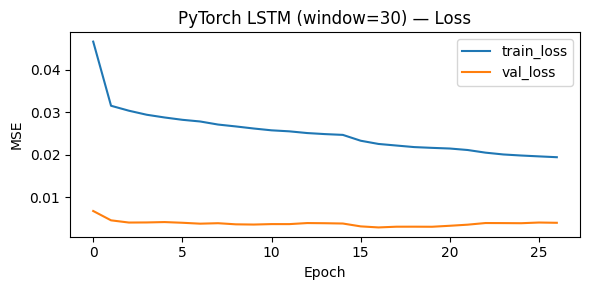

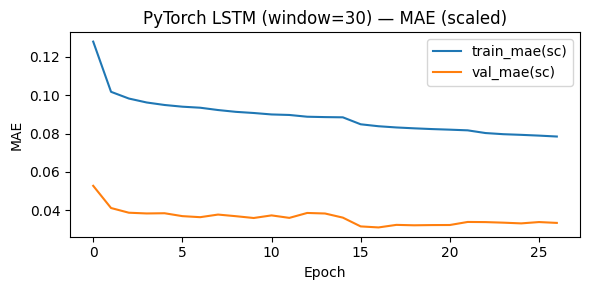

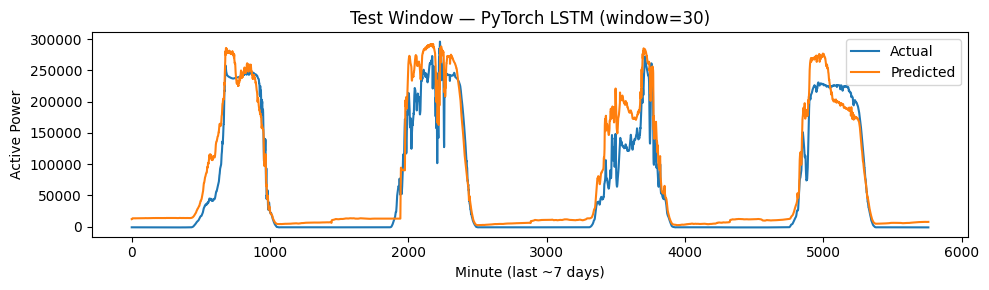

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | loss 0.0455 val_loss 0.0082 | mae(sc) 0.1240 val_mae(sc) 0.0543 | mape% 65.63 val_mape% 13.44
Epoch 002 | loss 0.0326 val_loss 0.0064 | mae(sc) 0.1019 val_mae(sc) 0.0473 | mape% 56.70 val_mape% 14.31
Epoch 003 | loss 0.0308 val_loss 0.0058 | mae(sc) 0.0981 val_mae(sc) 0.0445 | mape% 50.23 val_mape% 15.31
Epoch 004 | loss 0.0299 val_loss 0.0055 | mae(sc) 0.0961 val_mae(sc) 0.0440 | mape% 50.09 val_mape% 13.81
Epoch 005 | loss 0.0292 val_loss 0.0052 | mae(sc) 0.0949 val_mae(sc) 0.0422 | mape% 47.65 val_mape% 13.32
Epoch 006 | loss 0.0285 val_loss 0.0048 | mae(sc) 0.0936 val_mae(sc) 0.0428 | mape% 47.42 val_mape% 12.11
Epoch 007 | loss 0.0281 val_loss 0.0048 | mae(sc) 0.0927 val_mae(sc) 0.0440 | mape% 48.88 val_mape% 12.44
Epoch 008 | loss 0.0277 val_loss 0.0044 | mae(sc) 0.0922 val_mae(sc) 0.0387 | mape% 47.61 val_mape% 11.74
Epoch 009 | loss 0.0271 val_loss 0.0042 | mae(sc) 0.0914 val_mae(sc) 0.0417 | mape% 47.14 val_mape% 11.85
Epoch 010 | loss 0.0266 val_loss 0.0039 | mae(

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


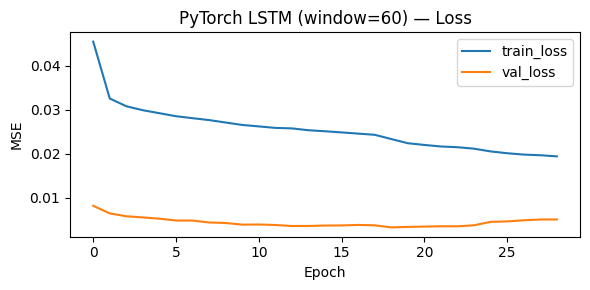

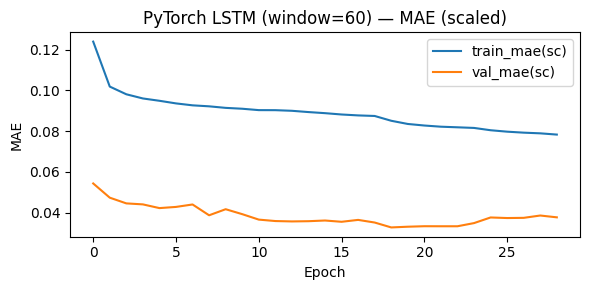

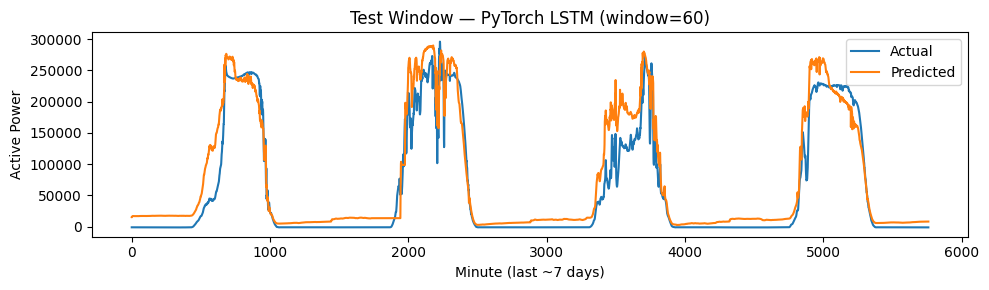

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | loss 0.0478 val_loss 0.0081 | mae(sc) 0.1281 val_mae(sc) 0.0521 | mape% 69.99 val_mape% 16.79
Epoch 002 | loss 0.0316 val_loss 0.0072 | mae(sc) 0.1019 val_mae(sc) 0.0488 | mape% 55.81 val_mape% 18.13
Epoch 003 | loss 0.0306 val_loss 0.0065 | mae(sc) 0.0997 val_mae(sc) 0.0481 | mape% 51.58 val_mape% 16.86
Epoch 004 | loss 0.0297 val_loss 0.0063 | mae(sc) 0.0969 val_mae(sc) 0.0520 | mape% 50.97 val_mape% 15.03
Epoch 005 | loss 0.0289 val_loss 0.0057 | mae(sc) 0.0954 val_mae(sc) 0.0483 | mape% 50.92 val_mape% 14.81
Epoch 006 | loss 0.0287 val_loss 0.0050 | mae(sc) 0.0950 val_mae(sc) 0.0454 | mape% 50.48 val_mape% 13.14
Epoch 007 | loss 0.0282 val_loss 0.0051 | mae(sc) 0.0938 val_mae(sc) 0.0438 | mape% 48.88 val_mape% 13.45
Epoch 008 | loss 0.0278 val_loss 0.0047 | mae(sc) 0.0930 val_mae(sc) 0.0422 | mape% 49.21 val_mape% 12.85
Epoch 009 | loss 0.0273 val_loss 0.0047 | mae(sc) 0.0924 val_mae(sc) 0.0418 | mape% 48.21 val_mape% 13.21
Epoch 010 | loss 0.0269 val_loss 0.0045 | mae(

/Users/hanouf/Desktop/SolarPowerProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[W=120] TEST: MAE=15648.556 RMSE=25336.162 R2=0.941


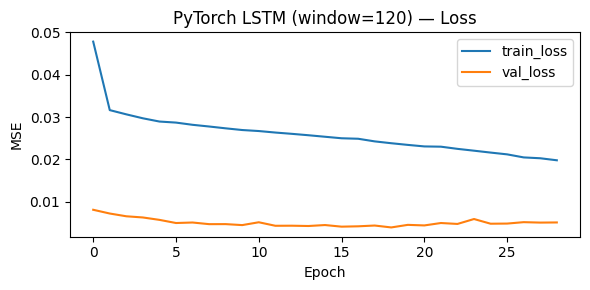

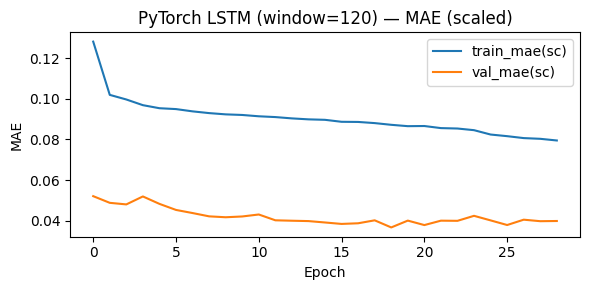

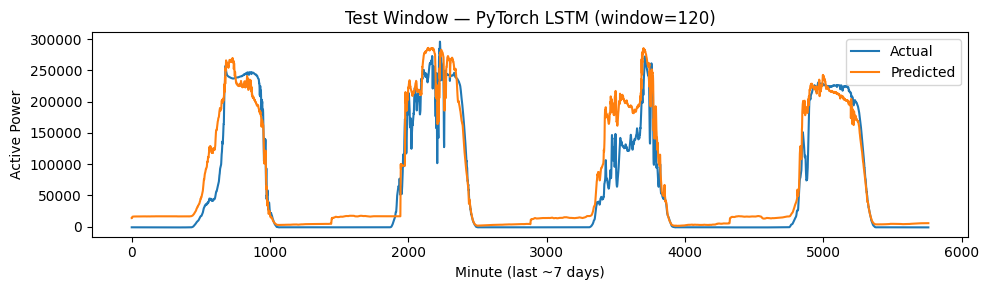

In [31]:
results_pt = {}

for W in WINDOW_SIZES:
    # build windowed tensors exactly like your TF code
    Xtr, ytr = make_sequences(X_train, y_train, window=W, horizon=HORIZON)
    Xva, yva = make_sequences(X_val,   y_val,   window=W, horizon=HORIZON)
    Xte, yte = make_sequences(X_test,  y_test,  window=W, horizon=HORIZON)

    model, hist = train_one_window("cnn-lstm",Xtr, ytr.ravel(), Xva, yva.ravel(), W)

    # test inference
    dte = DataLoader(SeqDataset(Xte, yte.ravel()), batch_size=BATCH_SIZE, shuffle=False)
    te_loss, y_true_sc, y_pred_sc = run_epoch(model, dte, nn.MSELoss(), optimizer=None)

    # inverse to original scale + metrics in your style
    mae, rmse, r2, y_true_inv, y_pred_inv = inverse_metrics(y_true_sc, y_pred_sc)
    results_pt[W] = {"history": hist, "metrics": (mae, rmse, r2), "y_true": y_true_inv, "y_pred": y_pred_inv}

    print(f"[W={W}] TEST: MAE={mae:.3f} RMSE={rmse:.3f} R2={r2:.3f}")

    # plots like your TF version
    plt.figure(figsize=(6,3))
    plt.plot(hist["loss"], label="train_loss"); plt.plot(hist["val_loss"], label="val_loss")
    plt.title(f"PyTorch LSTM (window={W}) — Loss"); plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(hist["mae"], label="train_mae(sc)"); plt.plot(hist["val_mae"], label="val_mae(sc)")
    plt.title(f"PyTorch LSTM (window={W}) — MAE (scaled)"); plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend(); plt.tight_layout(); plt.show()

    steps = min(len(y_true_inv), 4*24*60)
    plt.figure(figsize=(10,3))
    plt.plot(y_true_inv[-steps:], label="Actual")
    plt.plot(y_pred_inv[-steps:], label="Predicted")
    plt.title(f"Test Window — PyTorch LSTM (window={W})")
    plt.xlabel("Minute (last ~7 days)"); plt.ylabel("Active Power")
    plt.legend(); plt.tight_layout(); plt.show()

    # save best checkpoint (state_dict) per window, match your naming
    torch.save(
        {
            "state_dict": model.state_dict(),
            "n_features": Xtr.shape[-1],
            "window": W,
            "target": TARGET,
            "features": FEATS,
            "scalers": {
                "x_scaler_path": "x_scaler.pkl",
                "y_scaler_path": "y_scaler.pkl",
            },
        },
        f"CNN_LSTM_IG{W}.pt"
    )


# Comparing 

weellll i collect the scores from the training and :

VanillaLSTM

- [W=30] TEST: MAE=16886.822 RMSE=28894.121 R2=0.924
- [W=60] TEST: MAE=16882.254 RMSE=28751.209 R2=0.924
- [W=120] TEST: MAE=17448.236 RMSE=29247.910 R2=0.922

StackedLSTM

- [W=30] TEST: MAE=14589.364 RMSE=25590.875 R2=0.940
- [W=60] TEST: MAE=14670.729 RMSE=26000.814 R2=0.938
- [W=120] TEST: MAE=14107.559 RMSE=25555.104 R2=0.940

BILSTM

- [W=30] TEST: MAE=15707.373 RMSE=28305.293 R2=0.927
- [W=60] TEST: MAE=15581.849 RMSE=27337.443 R2=0.932
- [W=120] TEST: MAE=15181.051 RMSE=27639.367 R2=0.930

CNN+LSTM 

- [W=30] TEST: MAE=15474.728 RMSE=25602.465 R2=0.940
- [W=60] TEST: MAE=15562.465 RMSE=25362.422 R2=0.941
- [W=120] TEST: MAE=15648.556 RMSE=25336.162 R2=0.941

In [15]:
RESULTS_MANUAL = [
    {"model":"VanillaLSTM", "window":30,  "MAE":16886.822, "RMSE":28894.121, "R2":0.924},
    {"model":"VanillaLSTM", "window":60,  "MAE":16882.254, "RMSE":28751.209, "R2":0.924},
    {"model":"VanillaLSTM", "window":120, "MAE":17448.236, "RMSE":29247.910, "R2":0.922},

    {"model":"StackedLSTM", "window":30,  "MAE":14589.364, "RMSE":25590.875, "R2":0.940},
    {"model":"StackedLSTM", "window":60,  "MAE":14670.729, "RMSE":26000.814, "R2":0.938},
    {"model":"StackedLSTM", "window":120, "MAE":14107.559, "RMSE":25555.104, "R2":0.940},

    {"model":"BILSTM",      "window":30,  "MAE":15707.373, "RMSE":28305.293, "R2":0.927},
    {"model":"BILSTM",      "window":60,  "MAE":15581.849, "RMSE":27337.443, "R2":0.932},
    {"model":"BILSTM",      "window":120, "MAE":15181.051, "RMSE":27639.367, "R2":0.930},

    {"model":"CNN+LSTM",    "window":30,  "MAE":15474.728, "RMSE":25602.465, "R2":0.940},
    {"model":"CNN+LSTM",    "window":60,  "MAE":15562.465, "RMSE":25362.422, "R2":0.941},
    {"model":"CNN+LSTM",    "window":120, "MAE":15648.556, "RMSE":25336.162, "R2":0.941},
]

In [16]:
LEADERBOARD = []
LEADERBOARD.extend(RESULTS_MANUAL)
df = pd.DataFrame(LEADERBOARD)

In [17]:
# pick a baseline = best Vanilla across windows
base = df[df["model"].str.lower().str.contains("vanilla")].sort_values("RMSE", ascending=True).head(1)

base_rmse = float(base["RMSE"].iloc[0])
base_mae  = float(base["MAE"].iloc[0])

df["ΔRMSE_vs_Vanilla_%"] = (df["RMSE"] - base_rmse) / base_rmse * 100.0
df["ΔMAE_vs_Vanilla_%"]  = (df["MAE"]  - base_mae ) / base_mae  * 100.0

# main rank: RMSE then MAE then -R2 (higher R2 is better)
df = df.sort_values(["RMSE","MAE","R2"], ascending=[True, True, False]).reset_index(drop=True)
df.insert(0, "Rank", np.arange(1, len(df)+1))

display_cols = ["Rank","model","window","RMSE","MAE","R2","ΔRMSE_vs_Vanilla_%","ΔMAE_vs_Vanilla_%"]
print(df[display_cols].to_string(index=False))


 Rank       model  window      RMSE       MAE    R2  ΔRMSE_vs_Vanilla_%  ΔMAE_vs_Vanilla_%
    1    CNN+LSTM     120 25336.162 15648.556 0.941          -11.877925          -7.307662
    2    CNN+LSTM      60 25362.422 15562.465 0.941          -11.786590          -7.817611
    3 StackedLSTM     120 25555.104 14107.559 0.940          -11.116419         -16.435572
    4 StackedLSTM      30 25590.875 14589.364 0.940          -10.992004         -13.581658
    5    CNN+LSTM      30 25602.465 15474.728 0.940          -10.951693          -8.337311
    6 StackedLSTM      60 26000.814 14670.729 0.938           -9.566189         -13.099702
    7      BILSTM      60 27337.443 15581.849 0.932           -4.917240          -7.702793
    8      BILSTM     120 27639.367 15181.051 0.930           -3.867114         -10.076871
    9      BILSTM      30 28305.293 15707.373 0.927           -1.550947          -6.959266
   10 VanillaLSTM      60 28751.209 16882.254 0.924            0.000000           0.000000

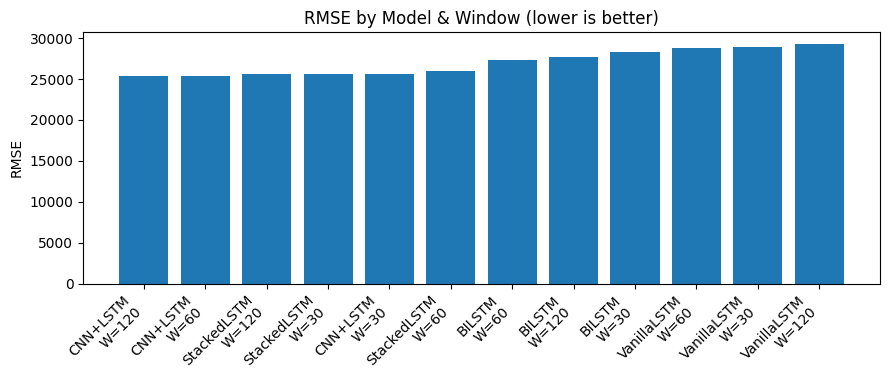

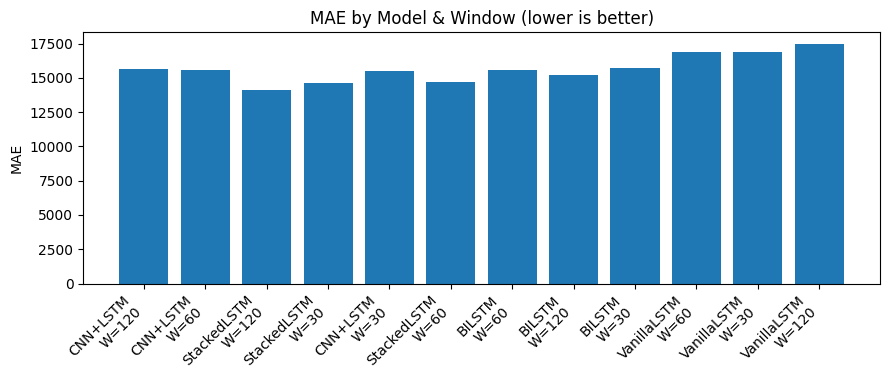

In [8]:
def barplot_metric(metric, title):
    plt.figure(figsize=(9,4))
    labels = [f"{m}\nW={w}" for m,w in zip(df["model"], df["window"])]
    vals   = df[metric].values
    plt.bar(labels, vals)
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

barplot_metric("RMSE", "RMSE by Model & Window (lower is better)")
barplot_metric("MAE",  "MAE by Model & Window (lower is better)")

In [18]:
best = df.iloc[0]
second = df.iloc[1]
print("\nin short:")
print(f"Top model: {best['model']} (W={int(best['window'])})  RMSE={best['RMSE']:.0f}, MAE={best['MAE']:.0f}, R2={best['R2']:.3f}")
print(f"Improvement vs Vanilla baseline: ΔRMSE={best['ΔRMSE_vs_Vanilla_%']:.1f}%, ΔMAE={best['ΔMAE_vs_Vanilla_%']:.1f}%")



in short:
Top model: CNN+LSTM (W=120)  RMSE=25336, MAE=15649, R2=0.941
Improvement vs Vanilla baseline: ΔRMSE=-11.9%, ΔMAE=-7.3%


yup me too i didn’t expect **CNN+LSTM** gonna be the best, i even was gonna skip it but yeah we should wait.... in Arabic we say *“الصبر مفتاح الفرج”* means Good things come to those who wait.

pretty on point for training deep models honestly

now i’ll stick with CNN+LSTM

*seeya*
